# Exploring if changes in cortical structures predict diagnosis in the ADNI dataset

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
ADNI_data=pd.read_csv('ADNIMERGE.csv',low_memory=False)
WD_Reason=pd.read_csv('WD_Reason_TREATDIS.csv',low_memory=False)

ADNI_data1=pd.merge(ADNI_data,WD_Reason,on='RID',how='inner')
print(f'Number of subjects: {ADNI_data1.shape[0]}')
ADNI_data1.head()

Number of subjects: 13306


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE_x,EXAMDATE_x,DX_bl,AGE,PTGENDER,...,RECNO,EXAMDATE_y,WDRAWTYPE,WDPARTIAL,WDREASON,WDPARTCOM,WDBURDEN,WDDETAILS,WDFOLLOWUP,update_stamp_y
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,3/16/2006,1.0,-4,1,subdural bleed relating to a fall,NaN,NaN,2,00:00.0
1,2,ADNI1,ADNI1,011_S_0002,11,m06,2006-03-06,CN,74.3,Male,...,NaN,3/16/2006,1.0,-4,1,subdural bleed relating to a fall,NaN,NaN,2,00:00.0
2,2,ADNI1,ADNI1,011_S_0002,11,m36,2008-08-27,CN,74.3,Male,...,NaN,3/16/2006,1.0,-4,1,subdural bleed relating to a fall,NaN,NaN,2,00:00.0
3,2,ADNIGO,ADNI1,011_S_0002,11,m60,2010-09-22,CN,74.3,Male,...,NaN,3/16/2006,1.0,-4,1,subdural bleed relating to a fall,NaN,NaN,2,00:00.0
4,2,ADNIGO,ADNI1,011_S_0002,11,m66,2011-03-04,CN,74.3,Male,...,NaN,3/16/2006,1.0,-4,1,subdural bleed relating to a fall,NaN,NaN,2,00:00.0


In [3]:
ADNI_data1.DX_bl.value_counts()

LMCI    5671
CN      3705
EMCI    1998
AD      1754
SMC      178
Name: DX_bl, dtype: int64

Where
<br>  LMCI: Late Mild Cognitive Impairment
<br>  CN: Healthy participant
<br>  EMCI: Early Mild Cognitive Impairment
<br>  AD: Alzheimer's Disease
<br>  SMC: Significant Memory Concern (self-reported from participant)

In [4]:
ADNI_data1['PTGENDER_cat'] = ADNI_data1['PTGENDER'].apply({'Male':0, 'Female':1}.get)
ADNI_data1['PTGENDER_cat'].unique()

array([0, 1])

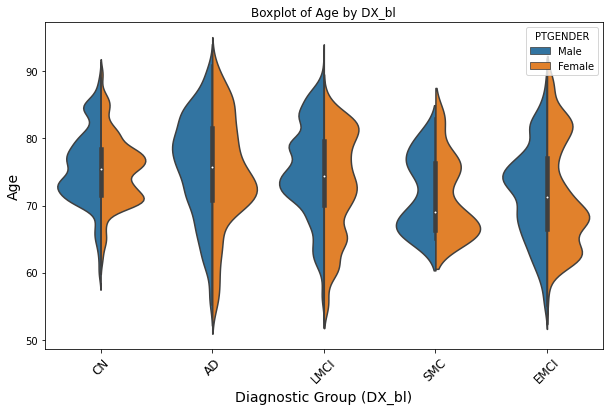

In [5]:
# Create a boxplot for Age of each DX_bl
plt.figure(figsize=(10, 6))
sns.violinplot(data=ADNI_data1, x='DX_bl', y='AGE',hue='PTGENDER',split=True)

plt.xlabel('Diagnostic Group (DX_bl)', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.title('Boxplot of Age by DX_bl')


plt.xticks(rotation=45, fontsize=12)
plt.show()

In [6]:
covs1=['AGE', 'PTGENDER_cat']
grouped_DX = [group_data[covs1] for group_name, group_data in ADNI_data1.groupby('DX_bl')]

f_statistic, p_value = f_oneway(*grouped_DX)
print("One-way ANOVA results:")
for i, stat in enumerate(f_statistic):
    print(f"{covs1[i]} F-statistic: {stat:.2f}, P-value: {p_value[i]:.0e}")

One-way ANOVA results:
AGE F-statistic: 116.81, P-value: 4e-98
PTGENDER_cat F-statistic: 87.50, P-value: 2e-73


Participants in the SMC EMCI and Controls groups appear to be younger. Males are relatively older than females in AD and EMCI groups

In [7]:
cortical_regs=['Ventricles','Hippocampus','WholeBrain','Entorhinal','Fusiform','MidTemp']
cov_info=['RID','AGE','ICV_bl','PTGENDER','DX_bl','PTGENDER_cat']
ADNI_data2=ADNI_data1[cov_info+cortical_regs]
ADNI_data2.describe()

,RID,AGE,ICV_bl,PTGENDER_cat,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp
count,13306.000000,13306.000000,1.321700e+04,13306.000000,7722.000000,6920.000000,7.934000e+03,6617.000000,6617.000000,6617.000000
mean,1875.282279,74.420818,1.548010e+06,0.425071,44233.420642,6516.595867,1.001492e+06,3364.482092,16747.672057,18854.664803
std,1749.320927,6.922937,1.685074e+05,0.494372,24008.925410,1227.637324,1.130652e+05,814.942879,2744.389852,3158.018114
min,2.000000,54.400000,1.100690e+06,0.000000,5650.000000,2219.000000,6.490910e+05,1041.000000,7739.000000,8044.000000
25%,539.000000,70.100000,1.426290e+06,0.000000,26755.000000,5644.000000,9.202880e+05,2784.000000,14902.000000,16809.000000
50%,1077.000000,74.300000,1.531740e+06,0.000000,39279.000000,6565.000000,9.958585e+05,3394.000000,16850.000000,18817.000000
75%,4120.000000,79.300000,1.658260e+06,1.000000,56409.500000,7424.075000,1.077390e+06,3952.000000,18569.000000,20966.000000
max,5295.000000,91.400000,2.110290e+06,1.000000,162729.000000,10452.000000,1.453280e+06,6420.000000,29950.000000,29779.000000


In [8]:
ADNI_clean = ADNI_data2.dropna()
ADNI_clean = ADNI_clean.reset_index(drop=True)
ADNI_clean.shape

(6241, 12)

In [9]:
ADNI_clean['PTGENDER'].unique()

array(['Male', 'Female'], dtype=object)

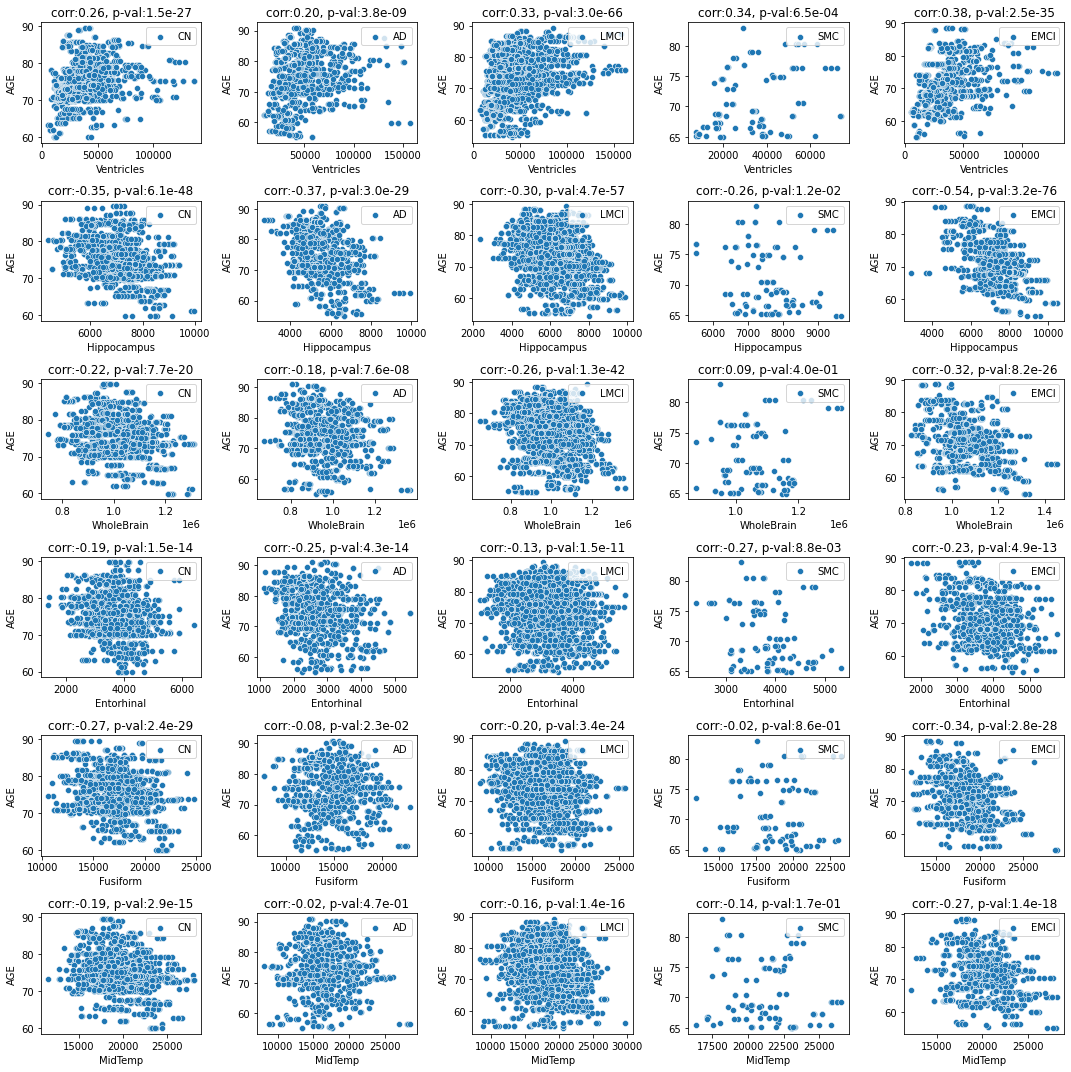

In [10]:
# Scatter plots and correlations of Age vs cortical regions
def scatter_plot(df,cov):
    num_rows = len(cortical_regs)
    num_cols = len(df['DX_bl'].unique())

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, column in enumerate(cortical_regs):
        for j, dx_class in enumerate(df['DX_bl'].unique()):
            data_class = df[df['DX_bl'] == dx_class]
            ax = axes[i, j]
            sns.scatterplot(x=data_class[column], y=data_class[cov], label=dx_class, ax=ax)

            corr, p_val = stats.pearsonr(data_class[column], data_class[cov])
            ax.set_title(f'corr:{corr:.2f}, p-val:{p_val:.1e}')

            ax.set_xlabel(column)
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    
scatter_plot(ADNI_clean,cov='AGE')

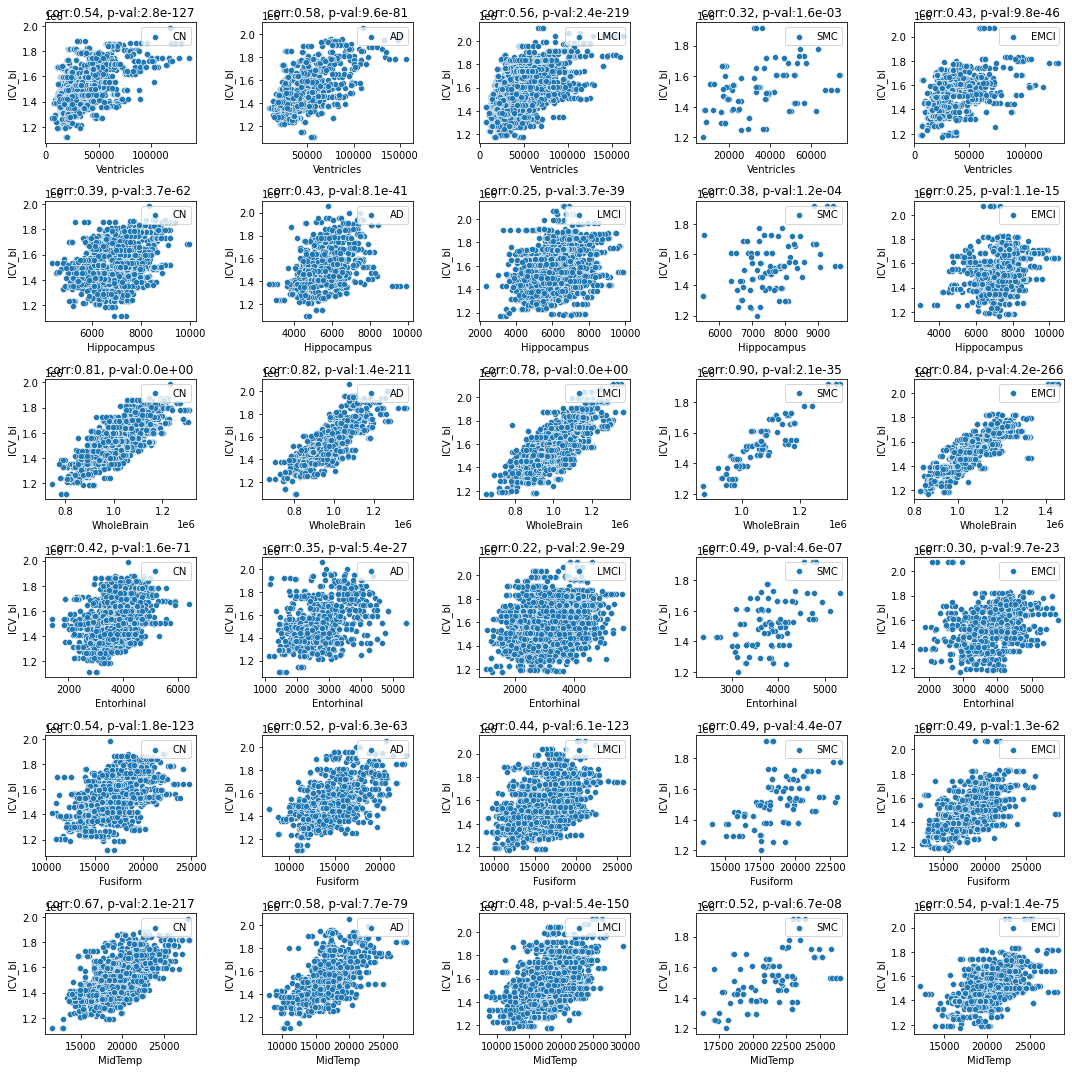

In [11]:
scatter_plot(ADNI_clean,cov='ICV_bl')

 <h3>Here we see that Age and ICV is correlated with cortical regions across all participants. Similarly, we can check the effects of Gender using violin plots and t-tests.</h3>

Violin plots for each cortical region compared to DX_bl groups


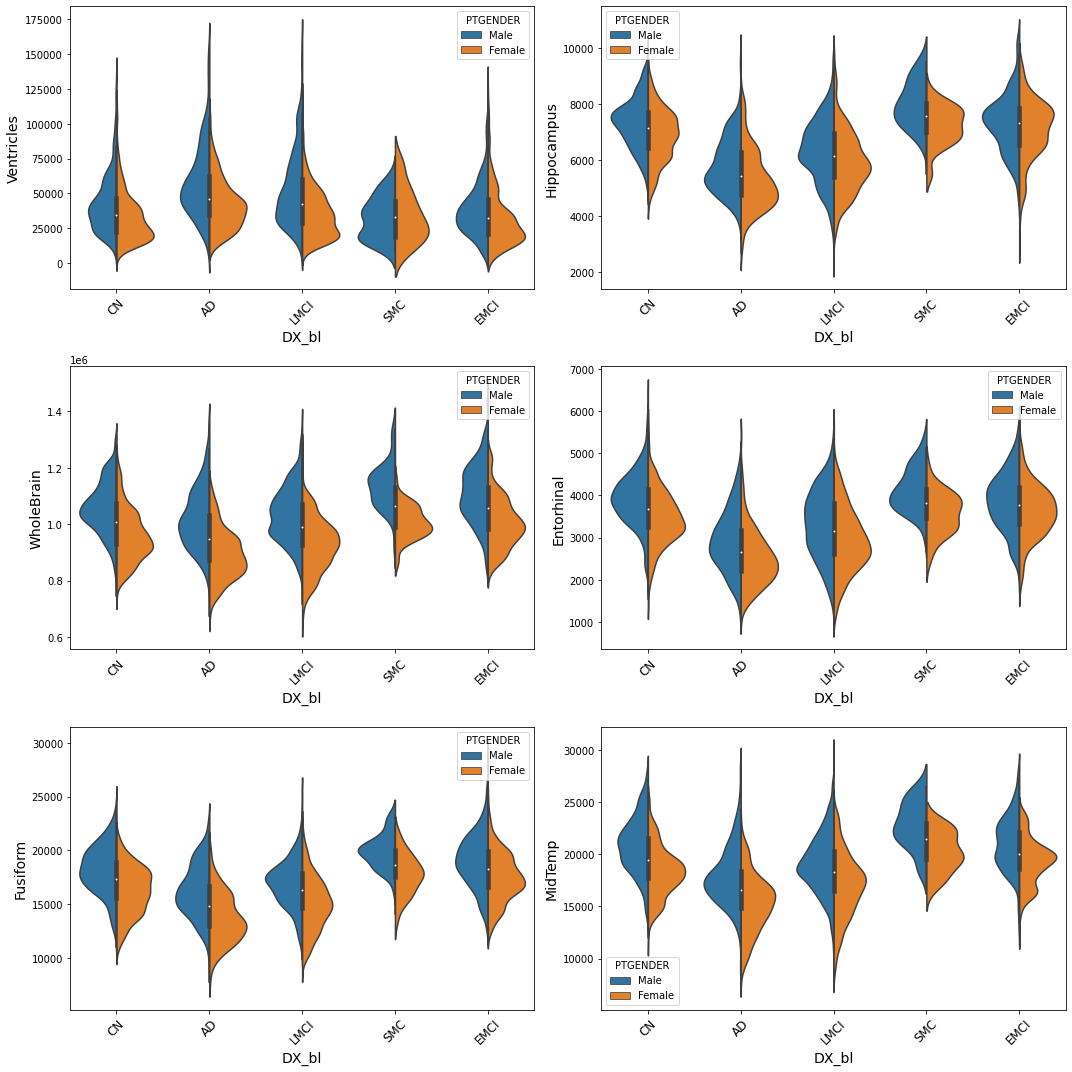

In [12]:
def mf_violin_plot(data):
    num_cortical_regs = len(cortical_regs)
    num_cols = 2 
    num_rows = (num_cortical_regs + num_cols - 1) // num_cols  
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.ravel()

    for i, cortical_reg1 in enumerate(cortical_regs):
        if i < num_cortical_regs:  
            ax = axes[i]
            sns.violinplot(data=data, x='DX_bl', y=cortical_reg1, hue='PTGENDER', split=True, ax=ax)

            ax.set_xlabel('DX_bl', fontsize=14)
            ax.set_ylabel(f'{cortical_reg1}', fontsize=14)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
            #ax.set_title(f'{cortical_reg1}', fontsize=16)
        else:
            fig.delaxes(axes[i]) 
    print('Violin plots for each cortical region compared to DX_bl groups')
    plt.tight_layout()
    plt.show()

mf_violin_plot(ADNI_clean)

In [13]:
def mf_t_test(data):
    results = []
    for cortical_reg1 in cortical_regs:
        #AD = [ADNI_clean['DX_bl'] == 'AD']
        reg=data[[cortical_reg1,'PTGENDER']]
        males = reg[reg['PTGENDER']=='Male']
        females = reg[reg['PTGENDER']=='Female']

        t_statistic, p_value = ttest_ind(males[cortical_reg1], females[cortical_reg1])
        results.append({'Cortical Region': cortical_reg1,
                        'T-statistic': t_statistic,
                        'p-value': p_value})

    results_df = pd.DataFrame(results)
    print("t-test of males vs females")
    print(results_df)

mf_t_test(ADNI_clean)

t-test of males vs females
  Cortical Region  T-statistic        p-value
0      Ventricles    25.474761  2.841022e-136
1     Hippocampus    11.281311   3.110305e-29
2      WholeBrain    41.385503   0.000000e+00
3      Entorhinal    17.243602   3.966307e-65
4        Fusiform    28.737396  1.139787e-170
5         MidTemp    28.699606  2.975886e-170


<h3>Thus, we see that Gender is also correlated with cortical regions. Therefore common practice is to regress Age, Gender and ICV before proceeding to further analysis.</h3>

In [14]:
covars = ['AGE','PTGENDER_cat','ICV_bl']
X = ADNI_clean.loc[:,covars]
X.head()

,AGE,PTGENDER_cat,ICV_bl
0,74.3,0,1984660.0
1,81.3,0,1920690.0
2,81.3,0,1920690.0
3,81.3,0,1920690.0
4,81.3,0,1920690.0


In [15]:
use_fit = (ADNI_clean.DX_bl=='CN')
use_fit.shape

(6241,)

In [16]:
def regressOut(y, X, use_fit=None):
    lm = linear_model.LinearRegression()    
    if use_fit is None:
        use_fit = [True] * X.shape[0]
    else:
        use_fit = use_fit.values

    x_mean = X.iloc[use_fit,:].mean()
    lm.fit(X.loc[use_fit,:].values, y.loc[use_fit])
    yhat = lm.predict(X.values)
    
    res = y - yhat
    offset = lm.predict(x_mean.values.reshape(1, -1))
    return(res + offset)

In [17]:
subj_features=ADNI_clean[cortical_regs]
subj_features_regress = subj_features.apply(lambda y: regressOut(y, X, use_fit))
subj_features_regress.shape

(6241, 6)

In [18]:
subj_features_regress1=pd.concat([subj_features_regress,ADNI_clean[cov_info]],axis=1)
subj_features_regress1

,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,RID,AGE,ICV_bl,PTGENDER,DX_bl,PTGENDER_cat
0,87946.602645,7209.462564,9.856409e+05,3392.353920,12804.189838,22523.873412,2,74.3,1984660.0,Male,CN,0
1,52715.324448,4788.982409,9.553809e+05,1285.034689,13183.301905,14569.569940,3,81.3,1920690.0,Male,AD,0
2,56696.324448,4915.982409,9.256109e+05,1921.034689,12077.301905,13119.569940,3,81.3,1920690.0,Male,AD,0
3,58215.324448,4626.982409,9.211909e+05,1090.034689,12294.301905,13477.569940,3,81.3,1920690.0,Male,AD,0
4,65536.324448,4608.982409,9.141109e+05,669.034689,11710.301905,12545.569940,3,81.3,1920690.0,Male,AD,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6236,81085.406553,6263.042233,9.164932e+05,4352.345251,17547.382942,16769.775800,1276,71.8,1417140.0,Female,CN,1
6237,81743.406553,6427.042233,9.180712e+05,3704.345251,18208.382942,16954.775800,1276,71.8,1417140.0,Female,CN,1
6238,87575.406553,6267.042233,9.089442e+05,3962.345251,17486.382942,16704.775800,1276,71.8,1417140.0,Female,CN,1
6239,98757.406553,6214.042233,9.345772e+05,3496.345251,16994.382942,16042.775800,1276,71.8,1417140.0,Female,CN,1


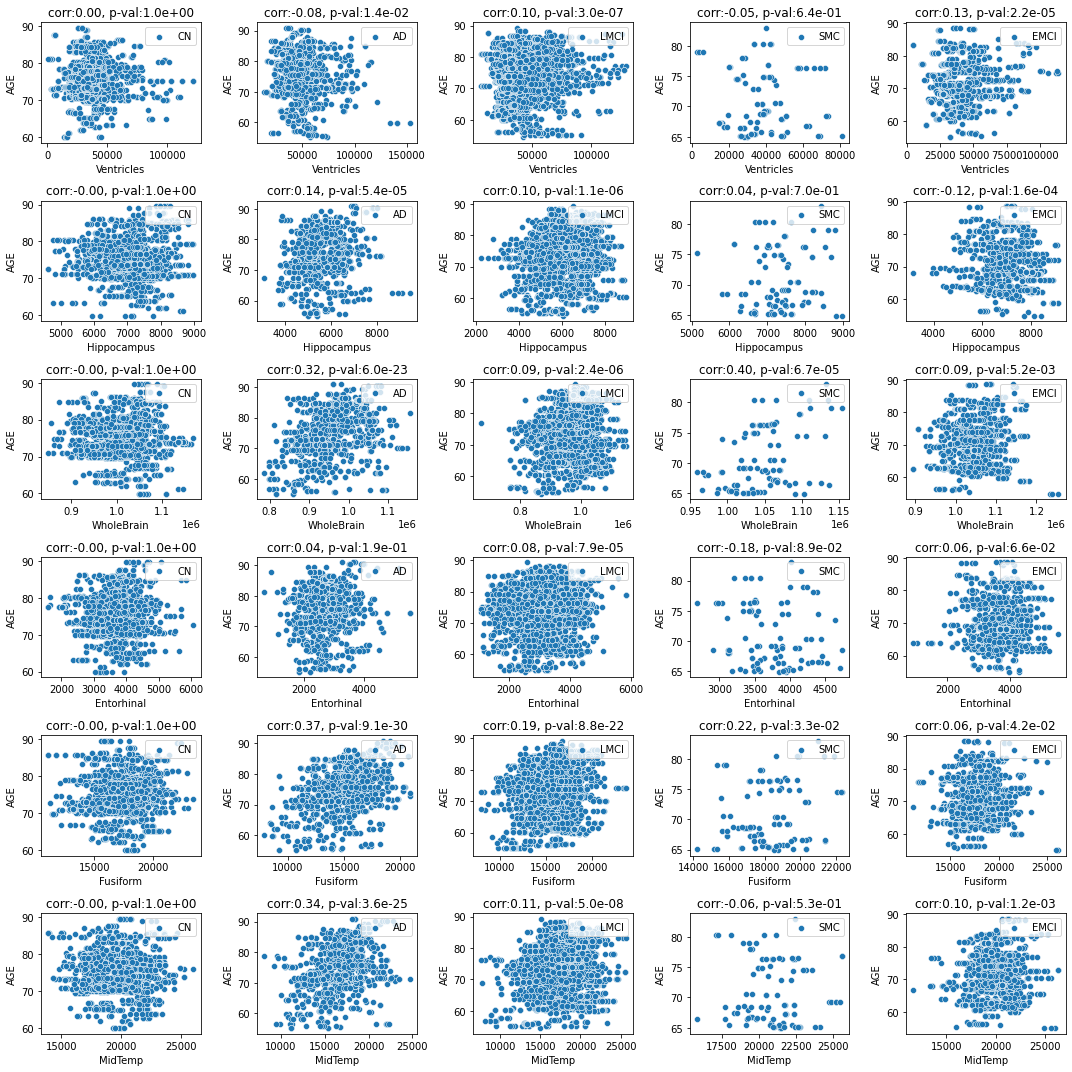

In [19]:
scatter_plot(subj_features_regress1,cov='AGE')

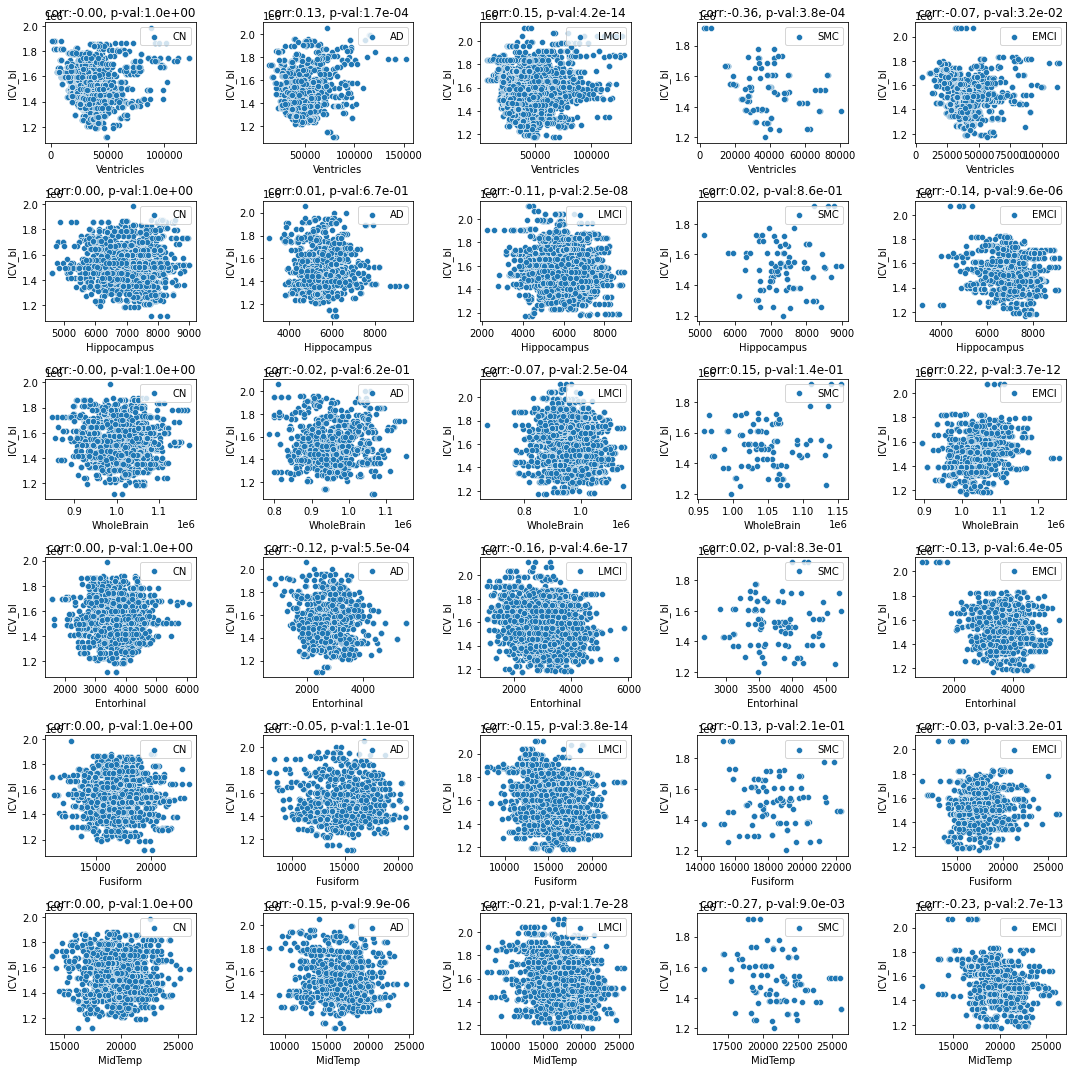

In [20]:
scatter_plot(subj_features_regress1,cov='ICV_bl')

Violin plots for each cortical region compared to DX_bl groups


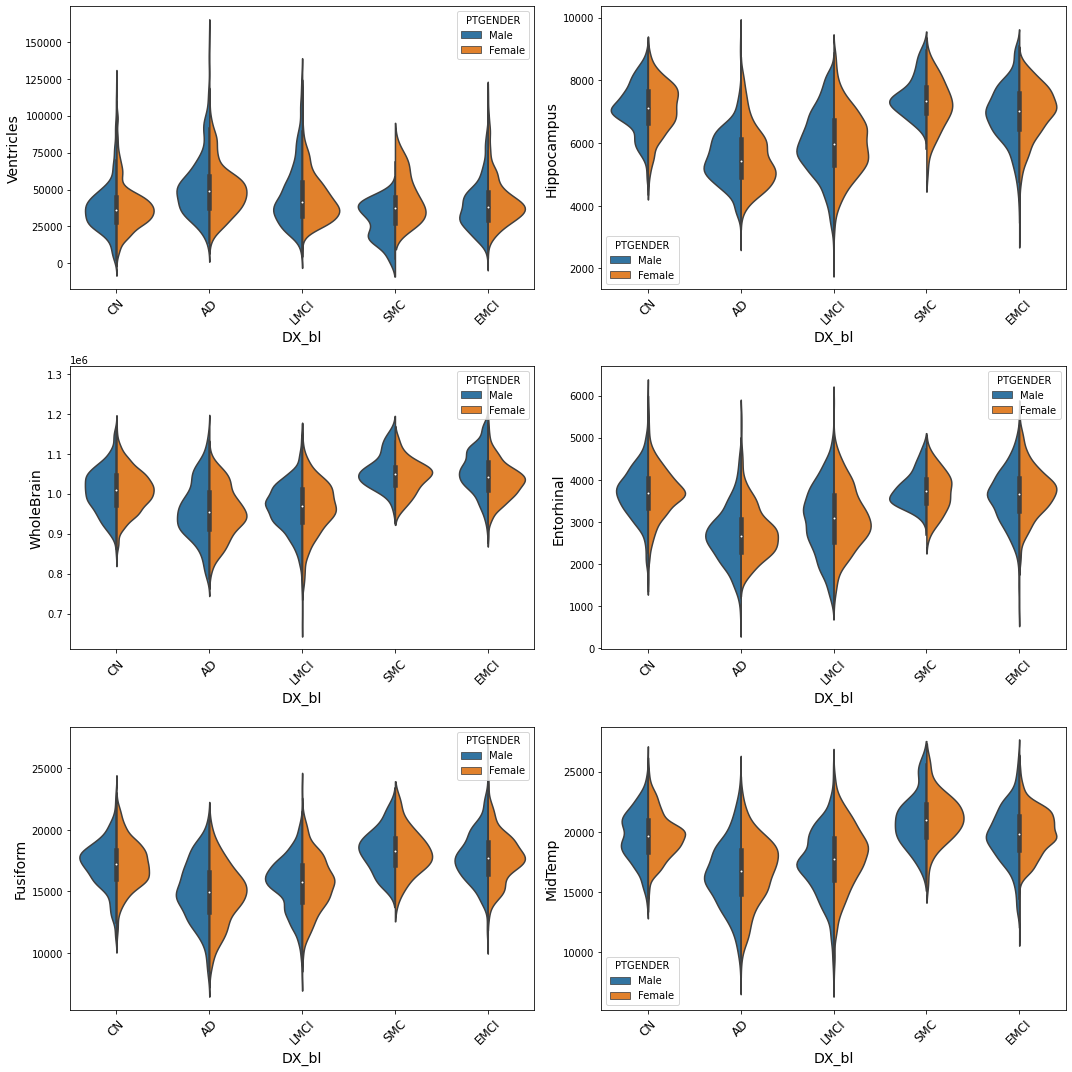

In [21]:
mf_violin_plot(subj_features_regress1)

In [22]:
mf_t_test(subj_features_regress1)

t-test of males vs females
  Cortical Region  T-statistic       p-value
0      Ventricles     2.630837  8.538421e-03
1     Hippocampus    -3.519714  4.350949e-04
2      WholeBrain     0.836938  4.026596e-01
3      Entorhinal    -5.545961  3.043394e-08
4        Fusiform    -1.680030  9.300163e-02
5         MidTemp    -7.386252  1.707741e-13


<h3>Thus, we succesfully removed the effects of Age, ICV and Gender from the cortical regions</h3>

In [23]:
#Build a logistic model for prediction
subj_features_regress1['DX_bl']=subj_features_regress1['DX_bl'].astype('category')
subj_features_regress1['DX_bl_cat'] = subj_features_regress1['DX_bl'].cat.codes
formula = "DX_bl_cat ~ Ventricles + Hippocampus + WholeBrain + Entorhinal + Fusiform + MidTemp"
log_reg = smf.mnlogit(formula, data=subj_features_regress1).fit()
print(log_reg.summary())


Optimization terminated successfully.
         Current function value: 1.084215
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:              DX_bl_cat   No. Observations:                 6241
Model:                        MNLogit   Df Residuals:                     6213
Method:                           MLE   Df Model:                           24
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                  0.1963
Time:                        15:39:47   Log-Likelihood:                -6766.6
converged:                       True   LL-Null:                       -8419.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
DX_bl_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.2693      0.960     -8.616      0.000     -10.150      -6.388
Ventricles  -7.709e-06   2

In [24]:
predicted_probs = log_reg.predict()

class_1_probs = predicted_probs[:, 0]
class_2_probs = predicted_probs[:, 1]
class_3_probs = predicted_probs[:, 2]
class_4_probs = predicted_probs[:, 3]

roc_auc_1 = roc_auc_score(subj_features_regress1['DX_bl_cat'] == 1, class_1_probs)
roc_auc_2 = roc_auc_score(subj_features_regress1['DX_bl_cat'] == 2, class_2_probs)
roc_auc_3 = roc_auc_score(subj_features_regress1['DX_bl_cat'] == 3, class_3_probs)
roc_auc_4 = roc_auc_score(subj_features_regress1['DX_bl_cat'] == 4, class_4_probs)

print(f"ROC AUC for Class 1: {roc_auc_1:.4f}")
print(f"ROC AUC for Class 2: {roc_auc_2:.4f}")
print(f"ROC AUC for Class 3: {roc_auc_3:.4f}")
print(f"ROC AUC for Class 4: {roc_auc_4:.4f}")

ROC AUC for Class 1: 0.2401
ROC AUC for Class 2: 0.6089
ROC AUC for Class 3: 0.3035
ROC AUC for Class 4: 0.1949


In [25]:
#Lets see if we can improve our predictions using a random forest model
# First we prepare our input data

X=subj_features_regress1[cortical_regs]
y=subj_features_regress1.DX_bl

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 120, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [2,4,6]
min_samples_split = [2,5,6,7]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)



{'n_estimators': [10, 22, 34, 46, 58, 71, 83, 95, 107, 120], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5, 6, 7], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [ ]:
import time


rf_Model = RandomForestClassifier()
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = 4)

start_time = time.time()
rf_Grid.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"RF Grid Model took {elapsed_time:.2f} seconds to run.");
#cleared cell output as its very long on the Github page

<h3>Here we see the rf_Grid.fit() took 5.97 minutes seconds to run</h3>

In [35]:
y_pred_prob_Grid = rf_Grid.predict_proba(X_test)
roc_auc_Grid = roc_auc_score(y_test, y_pred_prob_Grid, multi_class='ovo')
print(f"ROC AUC for rf_Grid model: {roc_auc_Grid:.4f}")

ROC AUC for rf_Grid model: 0.8110


In [ ]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

start_time = time.time()
rf_RandomGrid.fit(X_train, y_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"RF RandomGrid Model took {elapsed_time:.2f} seconds to run.")

<h3>Using rf_RandomGrid.fit() we reduced our train time to 7.32 seconds.</h3>

In [38]:
y_pred_prob_RandomGrid = rf_RandomGrid.predict_proba(X_test)
roc_auc_RandomGrid = roc_auc_score(y_test, y_pred_prob_RandomGrid, multi_class='ovo')
print(f"ROC AUC for rf_RandomGrid model: {roc_auc_RandomGrid:.4f}")

ROC AUC for rf_RandomGrid model: 0.8097
